In [603]:
# # colab
# import os
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/light beam')

In [604]:
import math
import pydicom
import numpy as np 
from scipy import ndimage
import matplotlib.pyplot as plt

In [605]:
dicom_file_path = 'images/DICOMOBJ/9x7-L'
H, W = (550, 1700), (600, 2100)

# Read the DICOM file
dicom_data = pydicom.dcmread(dicom_file_path)
arr = dicom_data.pixel_array[H[0]: H[1], W[0]: W[1]] # crop aspect
h, w = arr.shape
h, w

(1150, 1500)

In [606]:
def display(arr, axis=False) :
    plt.imshow(arr, cmap="gray")
    plt.axis(axis)

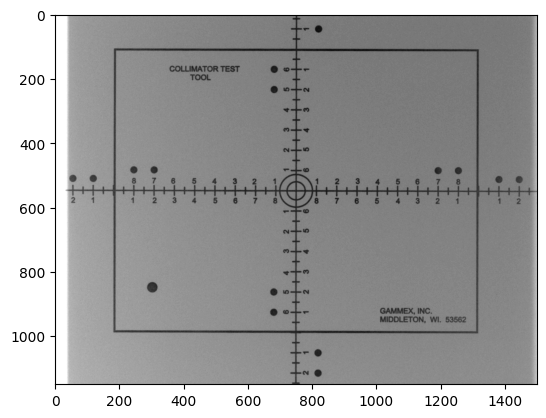

In [607]:
display(arr, True)

In [608]:
def find_common_value(focus_arr, axis=0) :
    """
    find common value of each row or colume
    agrs: axis=0 - col, axis=1 - row
    return: most common pixel value
    """
    vals = np.argmin(focus_arr, axis=axis) #[b, w] color
    unique_elements, counts = np.unique(vals, return_counts=True)
    most_common_index = np.argmax(counts)
    val = unique_elements[most_common_index]
    return val

In [609]:
def find_center_line(arr: np.array, visualize=True) :
    """
    find horizontal center line
    Return: (x1, y1), (x2, y2)
    """
    h, w = arr.shape
    hp = int(0.15*h) # crop ratio
    wp = int(0.05*w)

    #left point
    focus_l = arr[hp: h-hp, wp: wp*2]
    y1 = find_common_value(focus_l, axis=0) + hp # because focus start at hp not 0

    #Right point
    focus_r = arr[hp: h-hp, w-(wp*2): w-wp]
    y2 = find_common_value(focus_r, axis=0) + hp 

    if visualize :
        plt.figure(figsize=(3, 6))
        plt.subplot(1, 2, 1)
        display(focus_l, axis=True)
        plt.tick_params(bottom=False, labelbottom=False) # hide x-axis

        plt.subplot(1, 2, 2)
        display(focus_r, axis=True)
        plt.tick_params(bottom=False, labelbottom=False)
        plt.suptitle(f"Center line is on \n{y1-hp} and {y2-hp} [y-axis]") # re-axis same as croped

    return (0, y1), (w, y2)

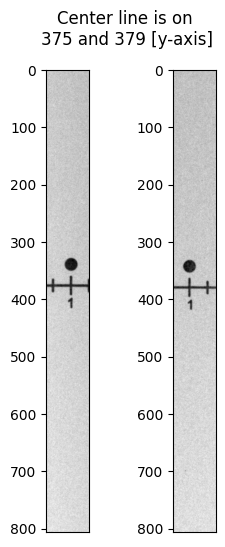

In [610]:
(x1, y1), (x2, y2) = find_center_line(arr)

In [611]:
def draw_line(arr, x1, y1, x2, y2) :
    plt.imshow(arr, cmap="gray")
    plt.plot([x1, x2], [y1, y2], color='blue', linewidth=1)
    plt.axis(False)

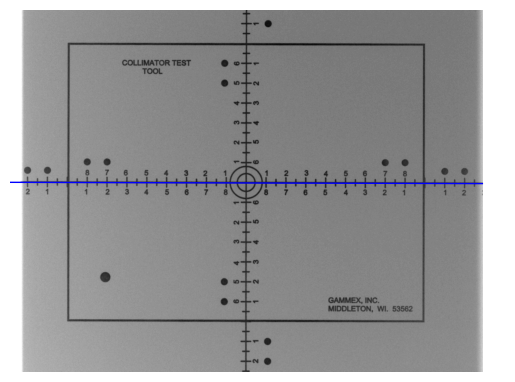

In [612]:
draw_line(arr, x1, y1, x2, y2)

In [613]:
def find_theta(w, y1, y2) :
    """
    find theta from y1, y2
    Return: theta in degree
    """
    a = y2-y1
    theta_r = math.asin(a/w)
    theta_d = math.degrees(theta_r)
    return theta_d

In [614]:
theta_d = find_theta(w, y1, y2)
theta_d

0.15278892645175646

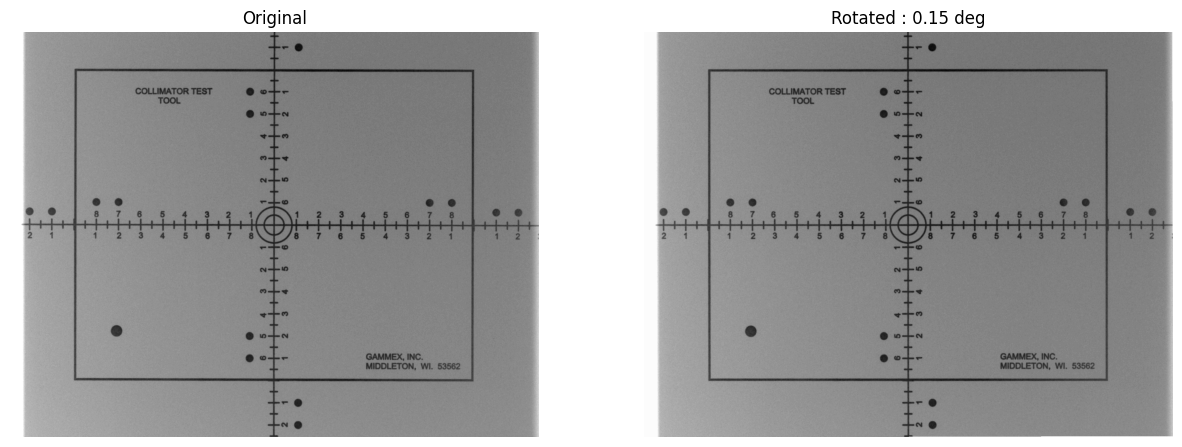

In [615]:
rotate_img = ndimage.rotate(arr, theta_d, reshape=False, cval=arr.max())

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Original")
display(arr)

plt.subplot(1, 2, 2)
plt.title(f"Rotated : {theta_d:.2f} deg")
display(rotate_img)

In [616]:
#find horizontal lines[y-axis]
def find_horizontal_line(arr: np.array):
    """
    Return: (top(y1, y2), center(y1, y2), bottom(y1, y2))
    """
    ypoints = []
    h, w = arr.shape
    hp = int(0.27*h) # crop ratio
    wp = int(0.07*w)

    # top line
    focus_l = arr[: hp, wp*2: wp*3]
    y1 = find_common_value(focus_l, axis=0)
    focus_r = arr[: hp, w-(wp*3): w-(wp*2)]
    y2 = find_common_value(focus_l, axis=0)
    ypoints.append((y1, y2))

    #center line
    (_, y1), (_, y2) = find_center_line(arr, visualize=False)
    ypoints.append((y1, y2))

    # bottom line
    focus_l = arr[h-hp: , wp*2: wp*3]
    y1 = find_common_value(focus_l, axis=0) + h-hp
    focus_r = arr[h-hp: , w-(wp*3): w-(wp*2)]
    y2 = find_common_value(focus_r, axis=0) + h-hp
    ypoints.append((y1, y2))

    return ypoints

In [617]:
ypoints = find_horizontal_line(rotate_img)
ypoints

[(111, 111), (549, 549), (986, 988)]

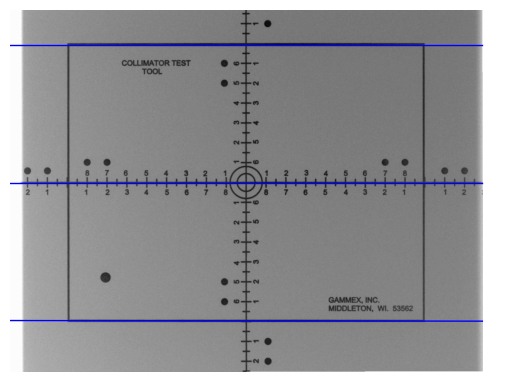

In [618]:
for idx in range(len(ypoints)) : 
    draw_line(rotate_img, 0, ypoints[idx][0], w, ypoints[idx][1])

In [619]:
#find vertical lines[x-axis]
def find_vertical_line(arr: np.array):
    """
    Return: (top(x1, x2), center(x1, x2), bottom(x1, x2))
    """
    xpoints = []
    h, w = arr.shape
    hp = int(0.05*h) # crop ratio
    wp = int(0.04*w)

    # left line
    focus_t = rotate_img[hp*3: hp*7, wp: wp*6]
    x1 = find_common_value(focus_t, axis=1) + wp
    focus_b = rotate_img[h-hp*7: h-hp*3, wp: wp*6]
    x2 = find_common_value(focus_b, axis=1) + wp
    xpoints.append((x1, x2))

    # right line
    focus_t = rotate_img[hp*3: hp*7, w-(wp*6): w-wp]
    x1 = find_common_value(focus_t, axis=1) + w-(wp*6)
    focus_b = rotate_img[h-hp*7: h-hp*3, w-(wp*6): w-wp]
    x2 = find_common_value(focus_b, axis=1) + w-(wp*6)
    xpoints.append((x1, x2))

    #center line
    hp = int(0.18*h)
    wp = int(0.2*w)

    focus_t = rotate_img[hp: hp*2, wp*2: wp*3]
    x1 = find_common_value(focus_t, axis=1) + (wp*2)
    focus_b = rotate_img[h-(hp*2): h-hp, wp*2: wp*3]
    x2 = find_common_value(focus_b, axis=1) + (wp*2)
    xpoints.append((x1, x2))

    # swap bottom and center in xpoints
    centerpoints = xpoints[-1]
    xpoints[-1] = xpoints[1]
    xpoints[1] = centerpoints
    return xpoints

In [620]:
xpoints = find_vertical_line(rotate_img)
xpoints

[(185, 186), (748, 749), (1311, 1311)]

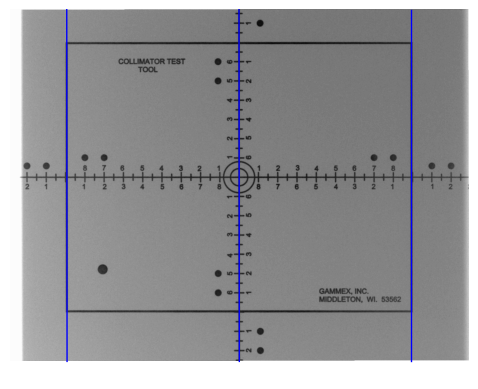

In [621]:
for idx in range(len(xpoints)) : 
    draw_line(rotate_img, xpoints[idx][0], 0, xpoints[idx][1], h)

In [622]:
xpoints = [round(np.mean(xpoints[idx])) for idx in range(3)]
ypoints = [round(np.mean(ypoints[idx])) for idx in range(3)]
xpoints, ypoints

([186, 748, 1311], [111, 549, 987])

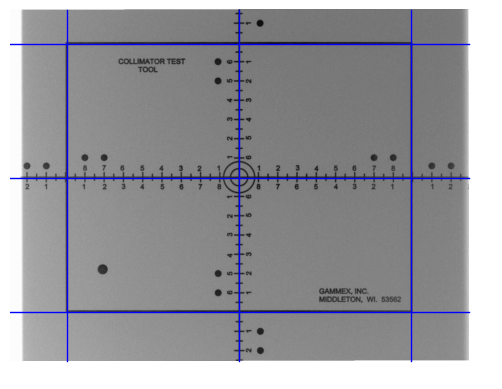

In [623]:
for idx in range(len(ypoints)) : 
    draw_line(rotate_img, xpoints[idx], 0, xpoints[idx], h)
    draw_line(rotate_img, 0, ypoints[idx], w, ypoints[idx])

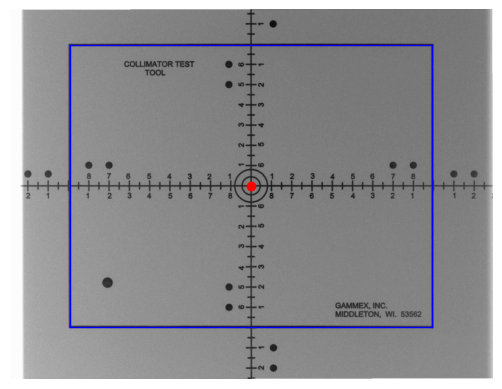

In [636]:
for idx in range(len(ypoints)) : 
    draw_line(rotate_img, xpoints[idx], ypoints[idx], xpoints[idx], ypoints[-idx-1])
    draw_line(rotate_img, xpoints[idx], ypoints[idx], xpoints[-idx-1], ypoints[idx])
plt.plot((xpoints[1]), (ypoints[1]), 'o', color="red")